# Przewidywanie oszustw w systemach płatności elektronicznych

Celem poniższego projektu jest analiza bazy danych 'Synthetic Financial Datasets For Fraud Detection' dostępnej na stronie www.kaggle.com oraz stworzenie modelu predykcyjnego, który pozwoli na wykrywanie oszustw w systemach płatonści elektronich. W tym celu skorzystamy z klasyfikacyjnego drzewa decyzyjnego.

### 1. Import

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection as cval
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df = df.rename(columns = {'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig',
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.shape

(6362620, 11)

In [3]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [4]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### 2. EDA

Jak widać poniżej, w zbiorze nie brakuje żadnych wartości, natomiast niektóre z obserwacji mają wartość 0 w miejscach, w których można by oczekawiać czegoś innego. Przejdziemy do tego w następnych punktach analizy.

In [5]:
df.isnull().values.any()

False

Liczba fałszywych transakcji w naszym zbiorze danych jest nieporównywalnie mniejsza od liczby prawdziwych transakcji, co może znacząco wpłynąć na wynik naszego modelu, do rozwiązania tego problemu przejdziemy przy podziale zbioru.

In [6]:
def check_how_many_frauds(df):
    frauds = pd.DataFrame(df['isFraud'].value_counts())
    frauds.rename(columns = {'isFraud': 'Num_of_obs'}, inplace = True)
    frauds['Per_of_obs'] = frauds['Num_of_obs']/df.shape[0]*100
    return frauds

check_how_many_frauds(df)

,Num_of_obs,Per_of_obs
0,6354407,99.870918
1,8213,0.129082


### 2.1 Które typy transakcji zawierają fałszywe obserwacje?

Szybkie sprawdzenie pokazuje, że jedynie transakcje typu wypłata i transfer zawierają sfałszowane dane.

In [7]:
dfFraudByType = pd.crosstab(df['type'],df['isFraud'])
dfFraudByType

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


### 2.2 Co wpływa na oflagowanie transakcji jako podejrzanej?

Jedną z kolumn w naszym zbiorze są transakcje oflagowane jako podejrzane. W opisie możemy przeczytać, że są to transfery o kwocie większej niż 200 000, łatwo jednak sprawdzić, że istnieje wiele transakcji które spełniają to kryterium a jednak nie zostały one oflagowane.

In [8]:
dfFlagged = df[df.isFlaggedFraud == 1]
dfNotFlagged = df[df.isFlaggedFraud == 0]
print('Ile transakcji zostało oflagowanych: %s' % (len(dfFlagged)))

Ile transakcji zostało oflagowanych: 16


In [9]:
dfTransfer = df[df.type == 'TRANSFER']
print('Ile transakcji ma kwotę większą niż 200 000 i nie zostało oflagowanych: %s' %
     (len(dfNotFlagged[dfNotFlagged.amount > 200000])))

Ile transakcji ma kwotę większą niż 200 000 i nie zostało oflagowanych: 1673554


Wiemy zatem, że flagowanie nie jest powiązane z kwotą przelewu, sprawdźmy zatem, czy stan konta ma wpływ na oznaczenie transakcji. Każda z 16 oflagowanych obserwacji ma wartości 'oldBalanceDest' i 'newBalanceDest' równe 0, czy zatem to może być powodem oznaczenia tych transakcji? Jak widzimy poniżej istnieje wiele innych transferów posiadających tę własność.

In [10]:
print('Ile transakcji nie oflagowanych ma powyższą własność: %s' %
     len(dfTransfer[(dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0) &
                    (dfTransfer.isFlaggedFraud == 0)]))

Ile transakcji nie oflagowanych ma powyższą własność: 4158


Może więc stan konta źródła transferu ma wpływ na oflagowanie transakcji? Jak widać poniżej wartości dla takich kont pokrywają się w znacznej mierze dla obserwacji oznaczonych jak i nie oznaczonych.

In [11]:
minmax = pd.DataFrame({'values':[round(dfFlagged.oldBalanceOrig.min()),
           round(dfFlagged.oldBalanceOrig.max()),
           round(dfTransfer[dfTransfer.isFlaggedFraud == 0].oldBalanceOrig.min()),
           round(dfTransfer[dfTransfer.isFlaggedFraud == 0].oldBalanceOrig.max()),
           round(dfFlagged.newBalanceOrig.min()),
           round(dfFlagged.newBalanceOrig.max()),
           round(dfTransfer[dfTransfer.isFlaggedFraud == 0].newBalanceOrig.min()),
           round(dfTransfer[dfTransfer.isFlaggedFraud == 0].newBalanceOrig.max())],
 'range_type':['min','max','min','max','min','max','min','max'],
 'is_flagged':['Flagged','Flagged','Not_Flagged','Not_Flagged','Flagged','Flagged','Not_Flagged','Not_Flagged'],
 'is_new':['old','old','old','old','new','new','new','new']
})

pd.pivot_table(minmax, values = 'values', index = ['is_new','is_flagged'], columns = 'range_type')


range_type                 max       min
is_new is_flagged                       
new    Flagged      19585040.0  353874.0
       Not_Flagged  49585040.0       0.0
old    Flagged      19585040.0  353874.0
       Not_Flagged  59585040.0       0.0

Pozostaje nam sprawdzić czy transakcje falgowane są na podstawie źródła i celu. Sprawdźmy czy osoby w 16 oflagowanych obserwacjach powtarzają się w innych.

In [12]:
allNamesNotFlagged = pd.concat([dfNotFlagged.nameOrig,dfNotFlagged.nameDest])

print('\n Czy źródła oflagowanych obserwacji pojawiają się znowu w innych transakcjach: %s' %
      (dfFlagged.nameOrig.isin(allNamesNotFlagged).any()))

print('\n Czy cele oflagowanych obserwacji pojawiają się znowu w innych transakcjach: %s' % 
     (dfFlagged.nameDest.isin(allNamesNotFlagged).any()))

print('\n Ile razy cele oflagowanych obserwacji pojawiają się w innych transakcjach: %s' % 
     (sum(dfFlagged.nameDest.isin(allNamesNotFlagged))))


 Czy źródła oflagowanych obserwacji pojawiają się znowu w innych transakcjach: False

 Czy cele oflagowanych obserwacji pojawiają się znowu w innych transakcjach: True

 Ile razy cele oflagowanych obserwacji pojawiają się w innych transakcjach: 2


Widzimy więc, że tylko 2 z 16 celów transakcji pojawia się w więcej niż jedenej obserwacji, stąd wiemy że, ustawianie flag nie jest powiązane z wcześniejszym użyciem tego konta. Odrzucamy zatem kolumnę 'isFlaggedFraud' w dalszej analizie, ponieważ nie jest ona powiązana z żadną ze zmiennych.

### 2.3 Czy konta których używano mają coś wspólnego z fałszywymi transakcjami?

W opisie datasetu możemy przeczytać, że fałszywe transkacje odbywają się w ramach schematu: transfer i następująca po nim wypłata. Sprawdźmy zatem czy konto będące celem fałszywego transferu jest również źródłem nieuczciwej wypłaty.

In [13]:
dfFraudTransfer = df[(df.type == 'TRANSFER') & (df.isFraud == 1)]
dfFraudCashOut = df[(df.type == 'CASH_OUT') & (df.isFraud == 1)]

dfFraudTransfer.nameDest.isin(dfFraudCashOut.nameOrig).any() 

False

Widzimy zatem, że zmienne 'nameOrig' i 'nameDest' nie są powiązane ze zmienną celu, więc odrzucimy je w dalszej analizie.

### 3.1 Czyszczenie danych

Zrzucamy nieistotne dla nas kolumny.

In [14]:
df_clean = df.drop(['nameOrig','nameDest','isFlaggedFraud'], axis = 1)

Jak widzieliśmy wcześniej, fałszywe transakcje występują jedynie w przypadku transferów i wypłat, ograniczamy się więc jedynie do tych typów.

In [15]:
df_clean = df_clean[(df_clean.type == 'TRANSFER') | (df_clean.type == 'CASH_OUT')]

Zmieniamy zmienną 'type' w zmienną binarną ponieważ algorytm CART z biblioteki sckit-learn nie obsługuje zmiennych kategorycznych.

In [16]:
df_clean['type'].replace(['TRANSFER','CASH_OUT'], [1,0], inplace = True)

### 3.2 Wstawianie brakujących danych

Pomimo, że na pierwszy rzut oka nie ma żadnych brakujących danych, to w wielu obserwacjach nie zmienia się stan konta celu, natomiast kwota transferu jest dodatnia. Liczbę takich transakcji podajemy poniżej (takich dla których stan konta jest równy zero)

In [17]:
len(df_clean[(df_clean.oldBalanceDest == 0) & (df_clean.newBalanceDest == 0) & (df_clean.amount > 0)])


5776

Sprawdźmy jaka cześć fałszywych transakcji ma podobną własność.

In [18]:
df_cleanFraud = df_clean[df_clean.isFraud == 1]
df_cleanNonFraud = df_clean[df_clean.isFraud == 0]

print('Część fałszywych transakcji, w której nie zmienia się stan konta celu: %s' % 
    (len(df_cleanFraud[(df_cleanFraud.oldBalanceDest == 0) & (df_cleanFraud.newBalanceDest == 0) & 
                       (df_cleanFraud.amount > 0)])/(1*len(df_cleanFraud))))

print('Część prawdziwych transakcji, w której nie zmienia się stan konta celu: %s' % 
     (len(df_cleanNonFraud[(df_cleanNonFraud.oldBalanceDest == 0) & (df_cleanNonFraud.newBalanceDest == 0) & 
                        (df_cleanNonFraud.amount > 0)])/(1*len(df_cleanNonFraud))))

Część fałszywych transakcji, w której nie zmienia się stan konta celu: 0.4955558261293072
Część prawdziwych transakcji, w której nie zmienia się stan konta celu: 0.0006176245277308345


Widzimy zatem, że o wiele cześciej zdarza się to w przypadku fałszywych transakcji, zatem nie będziemy wstawiać żadnych wartości w miejsce zerowych stanów konta, gdyż może być to jeden z czynników decydujących o prawdziwości transakcji.

### 4. Badanie zależności pomiędzy zmienną celu a pozostałymi zmiennymi

Ze względu na występowanie zależności omawianej przez nas w poprzednim punkcie wprowadzimy dodatkowe zmienne 'errorBalanceOrig' i 'errorBalanceDest', które mierzą rozbieżność pomiędzy oczekiwanym stanem konta a rzeczywistym.

In [19]:
df_clean['errorBalanceOrig'] = df_clean.newBalanceOrig + df_clean.amount - df.oldBalanceOrig
df_clean['errorBalanceDest'] = df_clean.oldBalanceDest + df_clean.amount - df.newBalanceDest

Do badania zależności użyjemy współczynnika rang Spearmana. Jest on niewrażliwy na wartości odstające, co jest dla nas istotne, ponieważ używany przez nas w dalszej części analizy algorytm drzewa decyzyjnego opiera się na proporcji obserwacji w zbiorze, a nie na zakresie występujących wartości.

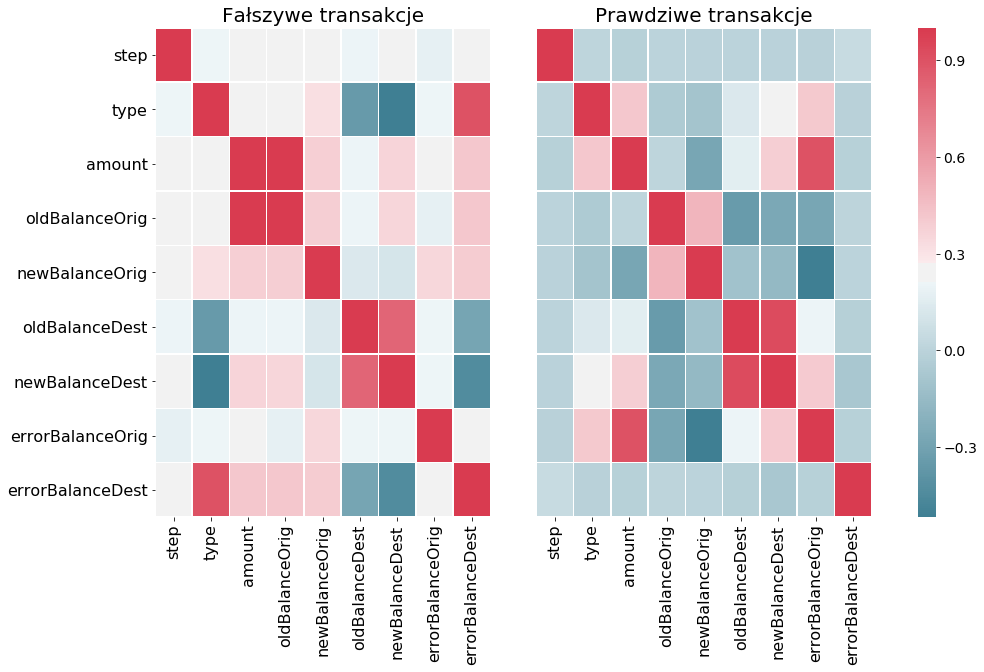

In [20]:
df_cleanFraud = df_clean[df_clean.isFraud == 1].drop('isFraud', axis = 1)
df_cleanNonFraud = df_clean[df_clean.isFraud == 0].drop('isFraud', axis = 1)

df_cleanSpearmanFraud = pd.DataFrame(stats.spearmanr(df_cleanFraud)[0], columns = df_cleanFraud.columns,
                                     index = df_cleanFraud.columns)
df_cleanSpearmanNonFraud = pd.DataFrame(stats.spearmanr(df_cleanNonFraud)[0], columns = df_cleanNonFraud.columns,
                                     index = df_cleanNonFraud.columns)

cmap = sns.diverging_palette(220, 8, as_cmap=True)
grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}

fig, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize = (14, 9))
ax1 = sns.heatmap(df_cleanSpearmanFraud, ax = ax1, linewidths = 0.5, cbar = False, cmap = cmap)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16)
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16) 
ax1.set_title('Fałszywe transakcje', size = 20)

ax2 = sns.heatmap(df_cleanSpearmanNonFraud, ax = ax2, cbar_ax = cbar_ax,
                  linewidths = 0.5, yticklabels = False, cmap = cmap)
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16)
ax2.set_title('Prawdziwe transakcje', size = 20)

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

Z powyższych wykresów można zaobserowawać różnice pomiędzy współczynnikami Spearman fałszywych i prawdziwych transakcji, odpowiednio dla różnych zmiennych.

### 5. Podział zbioru

Jak widać poniżej, pomimo ograniczenia się do transakcji typu transfer i wypłata, nasz zbiór danych nadal jest mocno niezrównoważony i prawdziwe transakcje stanowią prawie całość tego zbioru. Zastosujemy zatem metodę usuwania części obserwacji tak aby zrównoważyć nasz zbiór (random under-sampling).

In [21]:
check_how_many_frauds(df_clean)

,Num_of_obs,Per_of_obs
0,2762196,99.703546
1,8213,0.296454


Zmniejszymy liczbę prawdziwych transakcji do 20000, tak aby nadal była większa od liczby fałszywych, ale jednocześnie nie stanowiła 99% całego zbioru.

In [22]:
X = df_clean.loc[:,~df_clean.columns.isin(['isFraud'])]
y = df_clean['isFraud']
rus = RandomUnderSampler(ratio = {1: 8213, 0:20000})
X_res, y_res = rus.fit_sample(X,y)

In [23]:
df_clean_res = pd.DataFrame(X_res, columns = X.columns)
df_clean_res['isFraud'] = y_res

Przejdźmy teraz do standardowego podziału zbioru na część testową, treningową i walidacyjną. Jako część testową weźmiemy 20% całego zbioru, natomiast pozostałe 80% podzielimy w proporcji 3:1 na część treningową i walidacyjną.

In [24]:
train_valid = df_clean_res.sample(frac = 0.8, random_state = 123456)

test = df_clean_res[~df_clean_res.index.isin(train_valid.index)]

X_train, X_val, y_train, y_val = train_test_split(train_valid.loc[:,train_valid.columns != 'isFraud'],
                                                 train_valid['isFraud'], test_size = 0.25, random_state = 0)

X_test = test.loc[:,test.columns != 'isFraud']
y_test = test['isFraud']

### 6.1 Użycie modelu drzewa decyzyjnego

Użyjemy teraz modelu drzewa decyzyjnego na części trenującej a następnie sprawdzimy jego poprawność przy użyciu zbioru walidacyjnego.

In [25]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_val)
accuracy_score(pred, y_val)

0.9973418394471026

Jak widać nasz model jest dość dokładny, sprawdźmy jeszcze wynik na tablicy pomyłek.

In [ ]:
pd.DataFrame(confusion_matrix(y_val,pred), columns = ['Pred_Non_Fraud','Pred_Fraud'],
             index = ['Act_Non_Fraud','Act_Fraud'])

,Pred_Non_Fraud,Pred_Fraud
Act_Non_Fraud,4035,6
Act_Fraud,9,1593


### 6.2 Walidacja krzyżowa

Wykonamy teraz 30 razy walidację krzyżową na 10, a następnie uśrednimy wynik, aby upewnić się że nasze oszacowanie trafności modelu nie jest dziełem przypadku.

In [ ]:
m = 0
for x in range(0,30):
    m += cval.cross_val_score(model, X_train, y_train, cv = 10).mean()
m/30

### 6.3 Optymalizajca głębokości drzewa

Użyjemy GridSearchCV do znalezienia optymalnej głębokości drzewa. Nie chcemy aby drzewo było przeuczone, ponieważ mogłoby wtedy źle działać na danych testowych (overfitting).

In [ ]:
parameters = {'max_depth': range(2,6)}

Skorzystamy teraz z GridSearchCV do znalezienia odpowiedniej głębokości a następnie dokonamy walidacji krzyżowej na 10 podzbiorach dla uśrednienia wyników.

In [ ]:
classif = GridSearchCV(DecisionTreeClassifier(),parameters, cv = 10)
classif.fit(X_train,y_train)
classif.best_params_

Sprawdźmy teraz wynik dla modelu przy optymalnej głębokości.

In [ ]:
classif.best_score_

### 7.1 Ostateczny model i test

In [ ]:
model = DecisionTreeClassifier(**classif.best_params_)
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [ ]:
print('Końcowy wynik: %s' % (accuracy_score(pred,y_test)))

### 7.2 Wizualizacja drzewa

In [ ]:
dot_data = export_graphviz(model, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=['Not a Fraud','Fraud'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph